In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
pd.options.display.max_columns = None

Vamos iniciar abrindo o nosso dataset e observando sua estutura:

In [3]:
df = pd.read_csv("../data/telco.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Adicionar Explicação sobre as colunas

Em seguida vamos ver os se os tipos que foram atribuídos automaticamente estão corretos:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Como pudemos observar, "Total Charges" está no formato object, quando na verdade deveria ser um float. Isso indica que provavelmente há algum valor na base que não está permitindo a conversão. Vamos descobrir qual é:

In [6]:
try:
    df["TotalCharges"] = df["TotalCharges"].astype("float")
except Exception as e:
    print(e)

could not convert string to float: ''


Agora que descobrimos, vamos trata-lo:

In [7]:
df['TotalCharges'].replace(" ", np.nan, inplace = True)

In [8]:
df = df.fillna({'TotalCharges': df["MonthlyCharges"] * 6})

In [9]:
df["TotalCharges"] = df["TotalCharges"].astype("float")

Como podemos observar no gráfico abaixo, não há valores nulos no dataset, portanto a princípio não precisamos nos preocupar com isso:

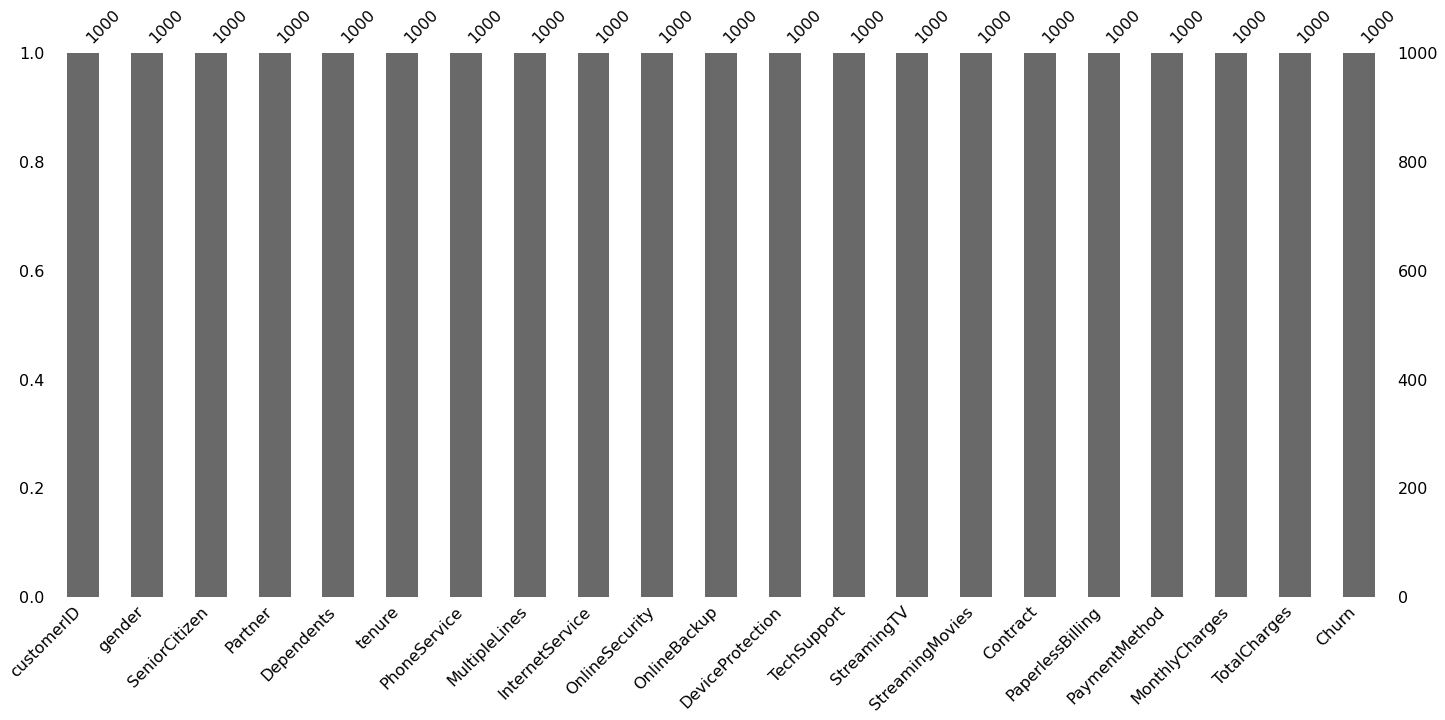

In [10]:
import missingno as msno
msno.bar(df.sample(1000))

Vamos entender as estatísticas do dataset

In [11]:
df.describe(include = "all")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,0581-BXBUB,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2280.122434,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.431689,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,399.350000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1394.550000,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3786.600000,NaN


Para a modelagem, é importante que separemos as variáveis categóricas das numéricas:

In [12]:
categorical_features = ['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn']

numerical_features = ["TotalCharges", "tenure", "MonthlyCharges"]

### 1 -  Exploração

Feitos os tratamentos inciais, podemos explorar os dados. Vamos iniciar observando a quantidade de cliente que tiveram ou não churn:

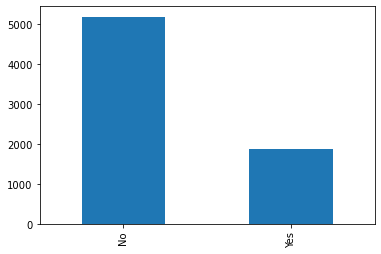

In [13]:
df["Churn"].value_counts().plot(kind = "bar")

Como podemos observar, o dataset está desbalanceado. Isso é um problema, uma vez que o modelo tenderá a trazer mais "Nãos" do que "Sims" como resultado, uma vez que o volume de aprendizado é diferente. Mais a frente, observaremos como contornar esse problema.

Agora, vamos observar como estão distribuidos os valores numéricos em relação aos clientes que tiveram churn:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFB4CA8850>,
      dtype=object)

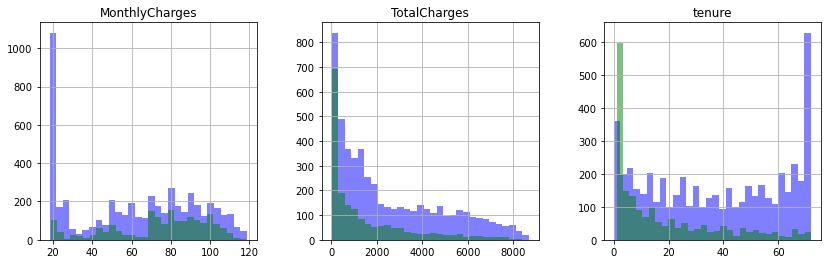

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4))
df[df.Churn == "No"][numerical_features].hist(bins = 30, color = "blue", alpha = 0.5, ax = ax)
df[df.Churn == "Yes"][numerical_features].hist(bins = 30, color = "green", alpha = 0.5, ax = ax)

Como podemos perceber no 2° gráfico, quanto maior o valor total gasto, maior a probabilidade de churn

Em seguida, vamos observar todos os valores categóricos da base:

In [15]:
def categorical_subplots(value, row, col):
    df[value].value_counts().plot.bar(ax = ax[row, col]).set_title(value)

In [16]:
shape = (4, 4)
categorical_features_array = np.array(categorical_features).reshape(shape[0], shape[1])

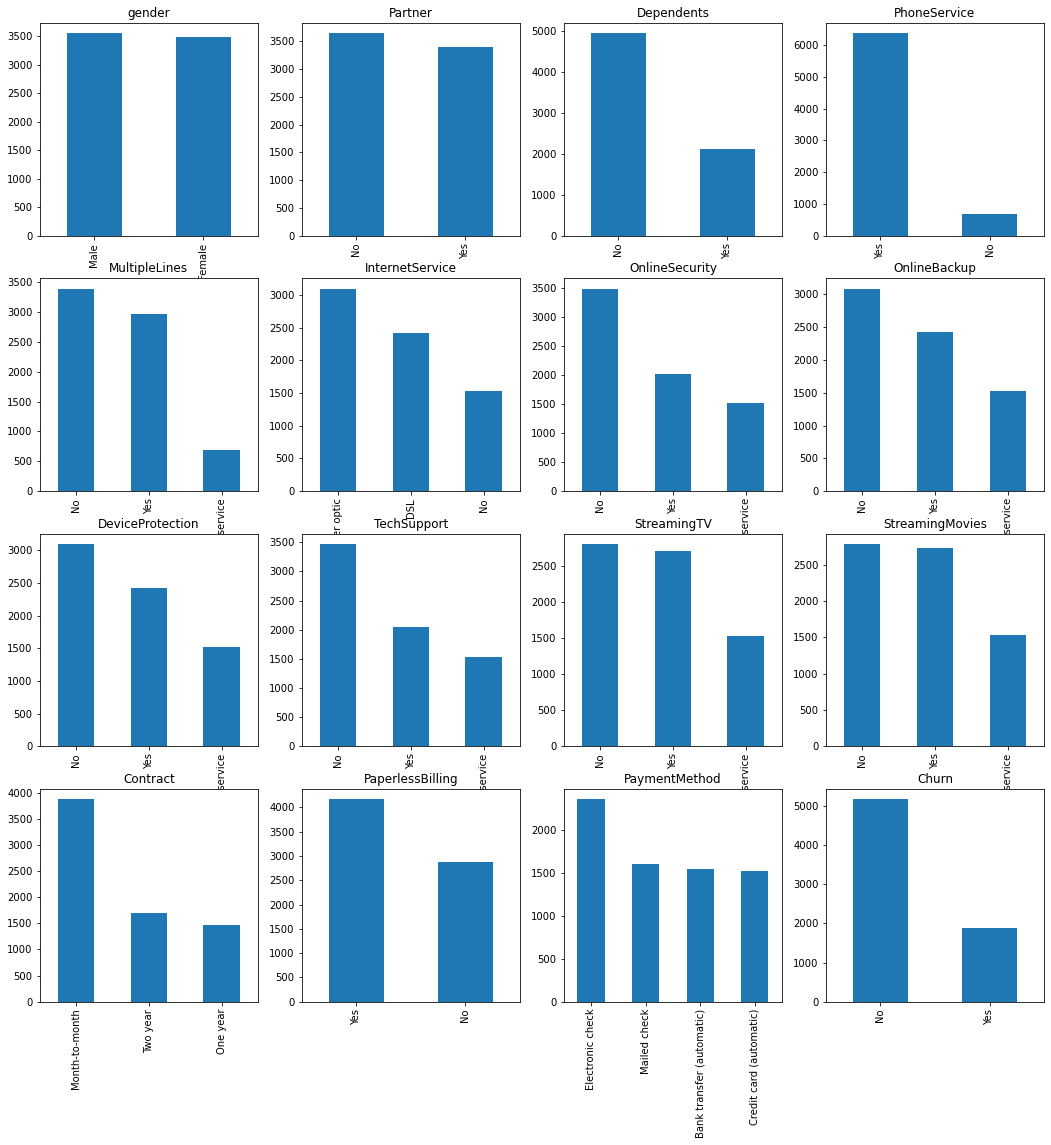

In [17]:
fig, ax = plt.subplots(shape[0], shape[1], figsize = (18, 18))
for (x,y), value in np.ndenumerate(categorical_features_array):
    categorical_subplots(value, x, y)

Ainda falando sobre os valores categóricos, vamos observar como eles se comportam em situação de churn e de "Não-Churn"

In [18]:
def compare_churned_columns(feature):
    fig, ax = plt.subplots(1, 2, figsize = (7, 2))
    df[df.Churn == "No"][feature].value_counts().plot(kind = "bar", ax=ax[0]).set_title("not churned: " + feature)
    df[df.Churn == "Yes"][feature].value_counts().plot(kind = "bar", ax=ax[1]).set_title("churned: " + feature)

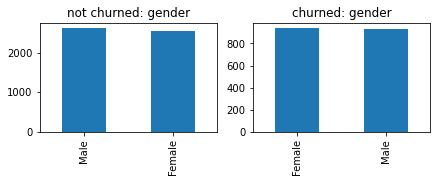

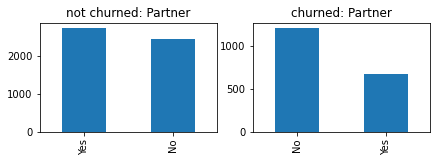

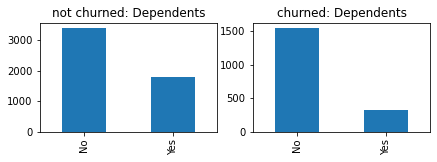

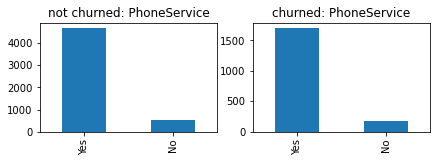

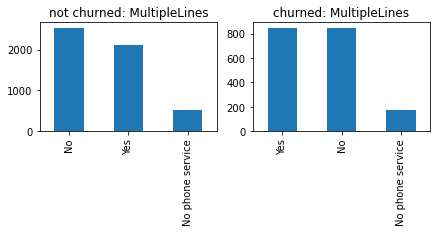

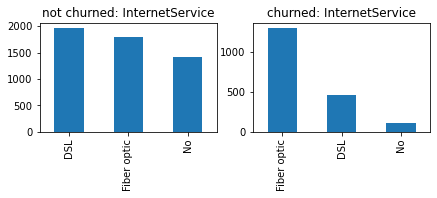

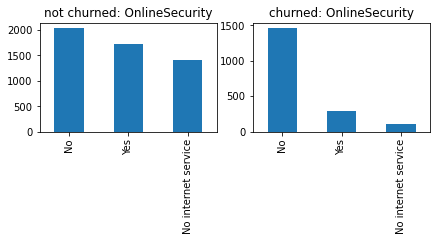

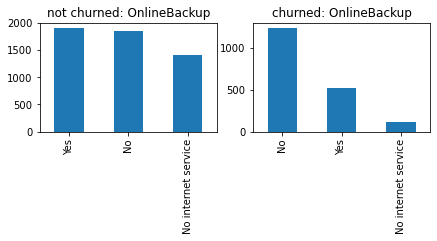

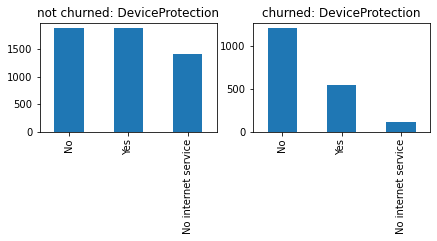

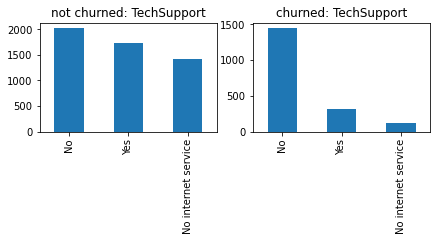

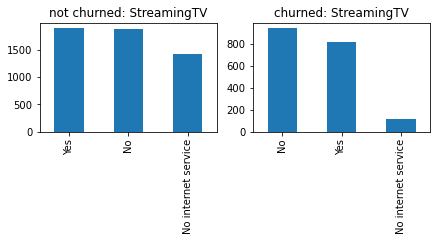

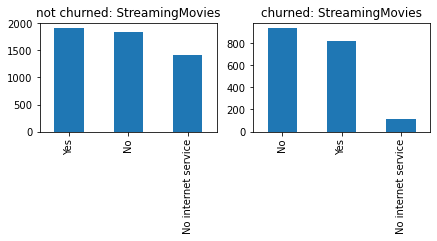

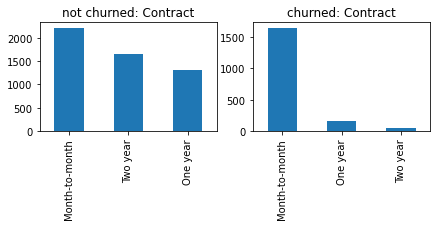

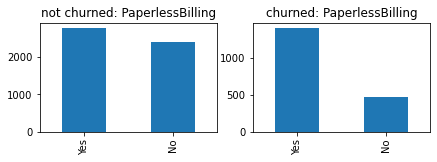

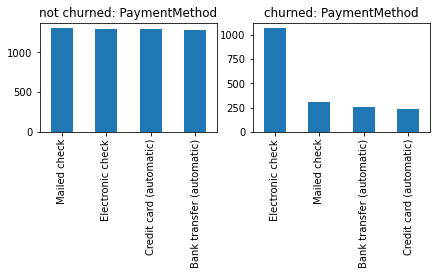

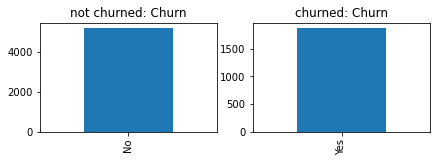

In [19]:
for feature in categorical_features:
    compare_churned_columns(feature)

A seguir vamos fazer a transformação de algumas variáveis para "Dummies". Elas são representadas em 0 e 1

In [20]:
num_df = pd.get_dummies(df[categorical_features])

for cat_column in categorical_features:
    text_label = LabelEncoder()
    num_label = text_label.fit_transform(df[cat_column])
    num_df[cat_column + '_cat'] = num_label

In [21]:
df = pd.concat([df, num_df], axis=1)

Uma vez definidas as variáveis dummies, vamos entender as correlações entre as colunas:

In [22]:
matrix = df.corr()

In [23]:
matrix.style.background_gradient()

Como visto acima, as correlações nos ajudam a ter uma noção de como os campos interagem entre si.

Conforme citado no início do artigo, o nosso dataset está desbalanceado. Uma vez que estamos próximos da etapa de treinamento, vamos fazer os ajustes necessários:

In [24]:
df_majority = df[df.Churn == "No"]
df_minority = df[df.Churn == "Yes"]

df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 5174,
                                 random_state = 1869)
 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
df_upsampled.Churn.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [25]:
df = df_upsampled

Para prosseguirmos, vamos filtrar apenas as colunas que contém valor numérico:

In [26]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data = df.select_dtypes(include = numerics)

In [27]:
target = df['Churn_cat']

In [28]:
data = data.drop("Churn_cat", axis = 1)

Uma vez que definimos todas as colunas categóricas como dummies, acabamos ficando com uma alta dimensionalidade dos dados, embora nem todos tenham significados realmente relevantes para o modelo. Dessa forma, vamos ver quais são as colunas mais representativas, utilizando o PCA.

In [29]:
x = data
y = target
x = StandardScaler().fit_transform(x)

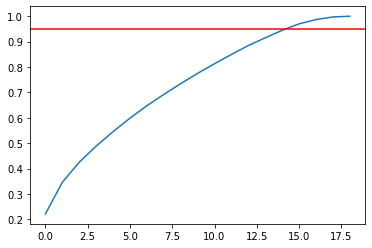

In [36]:
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.95, color = 'r', linestyle = '-')

In [32]:
n_components = 15
columns_pca = list()
for item in range(1, n_components + 1):
    columns_pca.append("pca" + str(item))

In [37]:
pca = PCA(n_components = 15)
principalComponents = pca.fit_transform(x)
data = pd.DataFrame(data = principalComponents, columns = columns_pca)

In [38]:
data

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
0,-2.181517,0.510285,3.043128,-0.391003,0.572731,-0.853948,1.163751,1.524763,-1.841790,0.125636,0.053435,-0.141113,-0.148275,-0.006785,0.132676
1,-0.803907,1.562655,0.544106,1.176943,-0.241497,1.185062,-0.847212,-0.050964,2.073422,-0.310325,1.485440,-0.325565,-1.486742,-1.036526,0.139826
2,0.441930,2.396389,3.286968,2.240500,0.177947,1.045401,0.073506,-1.727864,0.353705,-0.220608,0.395508,-0.751945,-0.126235,1.078449,-0.285355
3,-0.020673,-1.048222,-0.125783,-1.329684,-0.148065,0.631910,-1.188437,0.778571,-1.889631,-0.378560,-0.032207,0.448914,-0.082976,0.761791,-1.628397
4,-2.711942,1.628094,2.774064,1.270170,0.459232,-0.735645,0.736192,0.598087,0.767367,-1.610794,-0.549289,-0.006824,-1.484483,-0.007519,-0.066000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,0.246552,0.106326,0.173429,0.878401,-1.835463,-0.903147,-0.599720,0.656353,-0.223625,1.357892,1.547692,-0.295418,-1.845521,0.315498,0.049234
10344,-0.880139,0.332920,0.945077,1.269986,-0.200936,-1.203557,-1.263248,0.895159,2.157676,-0.207307,0.655734,-1.840250,0.148419,1.521376,0.058024
10345,-2.908582,-1.237728,-0.108904,-0.116139,-1.174252,-0.538557,1.065355,-0.059944,0.769867,1.105629,-0.158416,-0.182484,0.421886,-0.455267,-0.059361
10346,1.600144,-2.365469,-0.673142,-0.022841,1.360281,1.007336,0.817900,-0.261307,1.566749,0.500384,-0.037700,-0.496739,1.602203,0.994615,-0.074698


Vamos separar em treino e teste:

In [39]:
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size = 0.3)

### 1 - Regressão Logística

In [40]:
modelLR = LogisticRegression()
modelLR.fit(x_train, y_train)

LogisticRegression()

In [41]:
predictLR = modelLR.predict(x_valid)
print('Logistic Regression: \n', classification_report(predictLR, y_valid))
print('Logistic Regression Accuracy: ', accuracy_score(predictLR, y_valid))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.71      0.80      0.75      1412
           1       0.81      0.73      0.77      1693

    accuracy                           0.76      3105
   macro avg       0.76      0.76      0.76      3105
weighted avg       0.77      0.76      0.76      3105

Logistic Regression Accuracy:  0.7619967793880837


### 2 - Random Forest

In [42]:
modelRF = RandomForestClassifier()
modelRF.fit(x_train, y_train)

RandomForestClassifier()

In [43]:
predictRF = modelRF.predict(x_valid)
print('Random Forest Classifier : \n', classification_report(predictRF, y_valid))
print('Random Forest Classifier Accuracy: ', accuracy_score(predictRF, y_valid))

Random Forest Classifier : 
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      1412
           1       0.94      0.84      0.89      1693

    accuracy                           0.88      3105
   macro avg       0.88      0.89      0.88      3105
weighted avg       0.89      0.88      0.88      3105

Random Forest Classifier Accuracy:  0.8830917874396135


### 3 - Gradient Boosting

In [44]:
modelGB = GradientBoostingClassifier()
modelGB.fit(x_train, y_train)

GradientBoostingClassifier()

In [45]:
predictGB = modelGB.predict(x_valid)
print('Gradient Boost Classifier : \n', classification_report(predictGB, y_valid))
print('Gradient Boost Classifier Accuracy: ', accuracy_score(predictGB, y_valid))

Gradient Boost Classifier : 
               precision    recall  f1-score   support

           0       0.73      0.83      0.78      1402
           1       0.84      0.75      0.80      1703

    accuracy                           0.79      3105
   macro avg       0.79      0.79      0.79      3105
weighted avg       0.79      0.79      0.79      3105

Gradient Boost Classifier Accuracy:  0.7871175523349436
